In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gretel-synthetics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gretel-synthetics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

from glob import glob
from datetime import timedelta

In [4]:
!ln -s /content/drive/MyDrive/Colab\ Notebooks/DACON/dacon-lettuce-generative /mydrive

In [5]:
!mkdir /content/dataset
!cd /mydrive; unzip open.zip -d /content/dataset

Archive:  open.zip
  inflating: /content/dataset/sample_submission.zip  
   creating: /content/dataset/test_input/
  inflating: /content/dataset/test_input/TEST_01.csv  
  inflating: /content/dataset/test_input/TEST_02.csv  
  inflating: /content/dataset/test_input/TEST_03.csv  
  inflating: /content/dataset/test_input/TEST_04.csv  
  inflating: /content/dataset/test_input/TEST_05.csv  
   creating: /content/dataset/test_target/
  inflating: /content/dataset/test_target/TEST_01.csv  
  inflating: /content/dataset/test_target/TEST_02.csv  
  inflating: /content/dataset/test_target/TEST_03.csv  
  inflating: /content/dataset/test_target/TEST_04.csv  
  inflating: /content/dataset/test_target/TEST_05.csv  
   creating: /content/dataset/train_input/
  inflating: /content/dataset/train_input/CASE_01.csv  
  inflating: /content/dataset/train_input/CASE_02.csv  
  inflating: /content/dataset/train_input/CASE_03.csv  
  inflating: /content/dataset/train_input/CASE_04.csv  
  inflating: /conten

In [6]:
def make_traindata_dgan(input_dir_list):
  train = pd.DataFrame()
  for i in range(len(input_dir_list)):
    train_df = pd.read_csv(input_dir_list[i])
    train = pd.concat([train, train_df])
  train['obs_time'] = pd.to_datetime(train['obs_time'])
  train['datetime'] = train['obs_time'] + train['DAT'].apply(lambda x: timedelta(days=x))

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  train.loc[train['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  train.loc[train['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # column 삭제
  col_names = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
  train = train[['datetime'] + col_names]

  return train

In [8]:
input_dir_list = sorted(glob('/content/dataset/train_input/CASE_20.csv'))
train_df = make_traindata_dgan(input_dir_list)

In [9]:
features = train_df.drop(columns='datetime').to_numpy()
features = features.reshape(-1, 24, features.shape[1])
print(features.shape)

(28, 24, 4)


In [10]:
synthesizer_dgan = DGAN.load(file_name='/mydrive/model_param/CASE_20/dgan/synthesizer_dgan.pkl')

In [14]:
_, synthetic_features = synthesizer_dgan.generate_numpy(features.shape[0])
print(synthetic_features.shape)

(28, 24, 4)


### Descriptive statistics: real vs synth

In [18]:
real = features.reshape(-1, features.shape[-1])
real_df = pd.DataFrame(real, columns=['temp', 'humidity', 'ec', 'co2'])

synth = synthetic_features.reshape(-1, features.shape[-1])
synth_df = pd.DataFrame(synth, columns=['temp', 'humidity', 'ec', 'co2'])

print(real_df.describe())
print('')
print(synth_df.describe())

             temp    humidity          ec          co2
count  672.000000  672.000000  672.000000   672.000000
mean    25.888889   74.780151    2.109596   541.333656
std      2.052768    8.899667    0.800423    98.697726
min     22.038596   43.893333    0.000000   356.925000
25%     23.931250   68.616667    2.356582   501.362500
50%     26.729167   78.510833    2.426089   542.266667
75%     27.406667   81.990000    2.517800   592.720833
max     30.306666   84.945000    2.577928  1125.333333

             temp    humidity          ec          co2
count  672.000000  672.000000  672.000000   672.000000
mean    25.945900   75.759819    2.019573   538.790283
std      2.004492    8.556129    0.891917    89.842293
min     22.228376   46.102448    0.000023   375.549103
25%     24.048586   71.697510    1.914810   477.959000
50%     26.666140   78.915203    2.510053   539.610260
75%     27.563646   82.700424    2.563168   591.660095
max     29.798315   84.914642    2.577806  1066.439209


### Compare sample plot: real vs synth

In [26]:
from pandas.io.formats import style
# Show a few of the 1-day training samples
xaxis_1day = train_df["datetime"][0:24]

def plot_day(real, synth):
  columns = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
  titles = ['Temperatture', 'Humidity', 'ec', 'co2']
  # colors = ['red', 'blue', 'orange', 'green']

  obs = np.random.randint(len(features))

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
  axs = axs.ravel(order='C')
  for i, c in enumerate(columns):
    axs[i].plot(xaxis_1day, real[obs][:,i], label='real', color='orange', linestyle='-')
    axs[i].plot(xaxis_1day, synth[obs][:,i], label='synth', color='blue', linestyle='--')
    axs[i].legend()
    axs[i].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(titles[i])
  plt.tight_layout()
  plt.show()

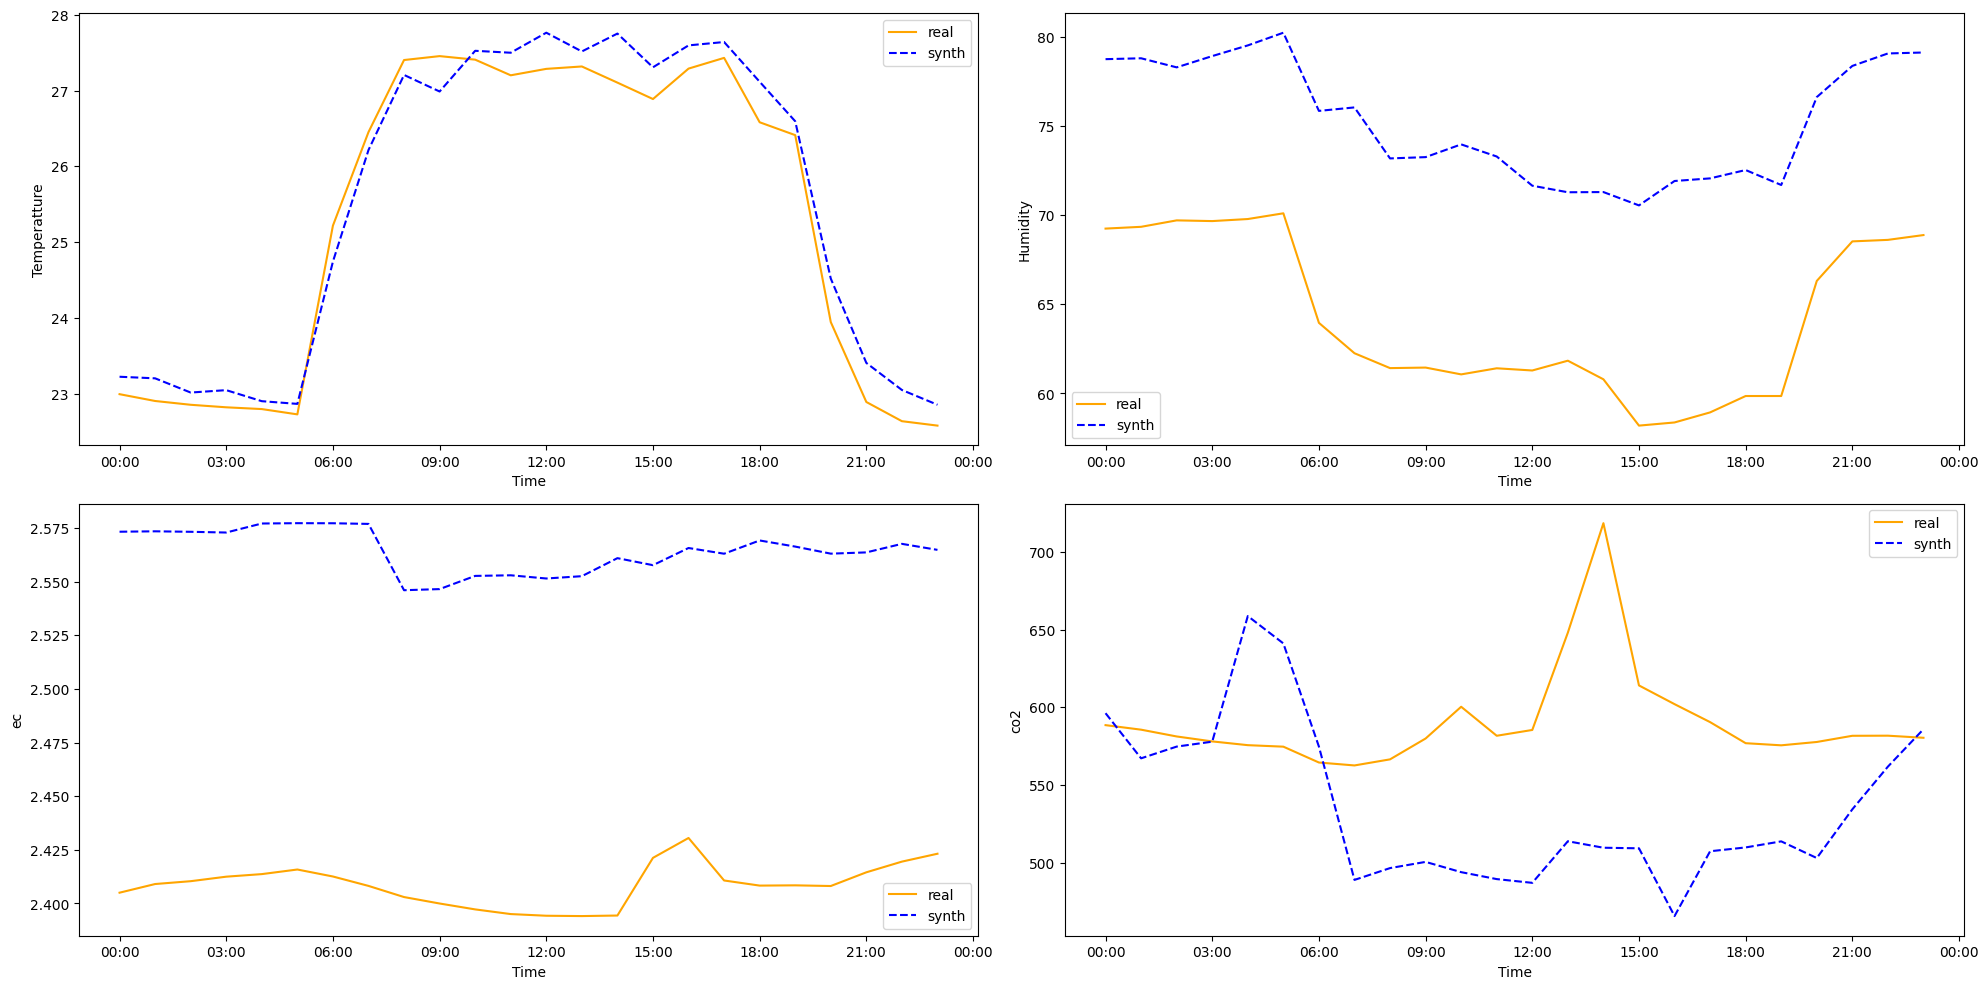

In [29]:
plot_day(features, synthetic_features)

### Box plot: real vs synth

In [32]:
def boxplot(real_df, synth_df, col):
  fig, ax = plt.subplots()
  ax.boxplot([real_df[col], synth_df[col]])
  plt.title('real vs synth')
  plt.xticks([1,2], [f'real_{col}', f'synth_{col}'])
  plt.show()

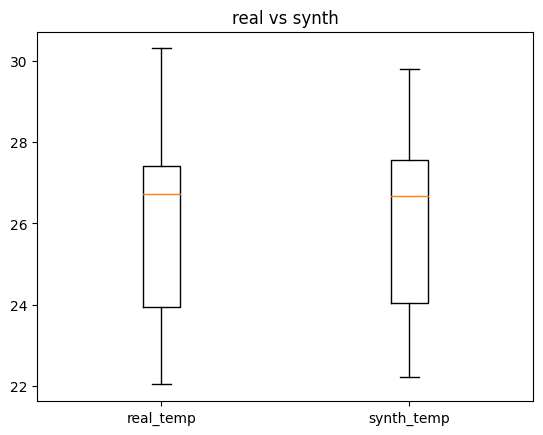

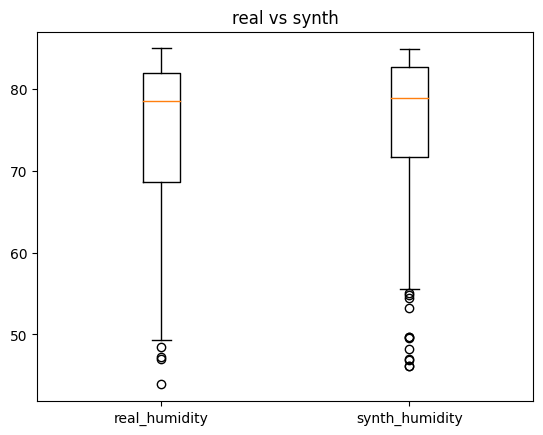

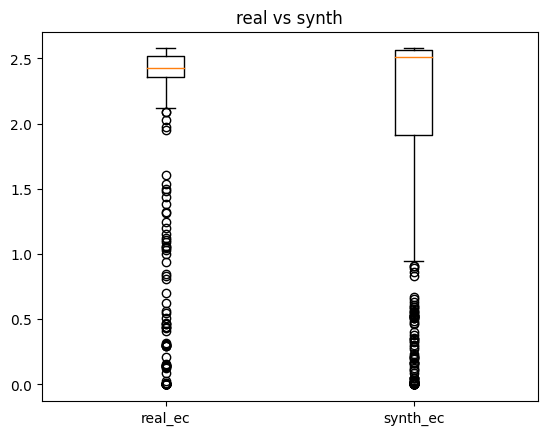

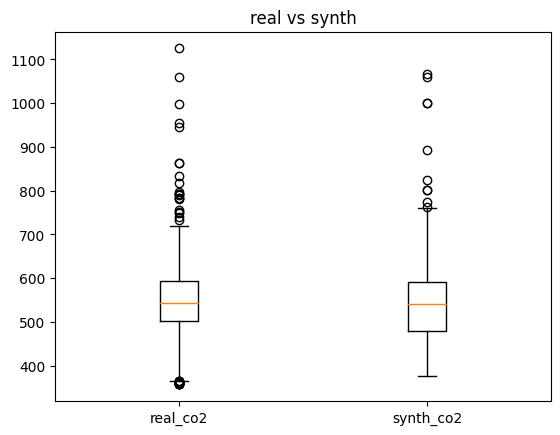

In [35]:
boxplot(real_df, synth_df, 'temp')
boxplot(real_df, synth_df, 'humidity')
boxplot(real_df, synth_df, 'ec')
boxplot(real_df, synth_df, 'co2')

### PCA & TSNE

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seq_len = 24
sample_size = 250
idx = np.random.permutation(len(features))[:sample_size]

real_sample = np.asarray(features)[idx]
synthetic_sample = np.asarray(synthetic_features)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

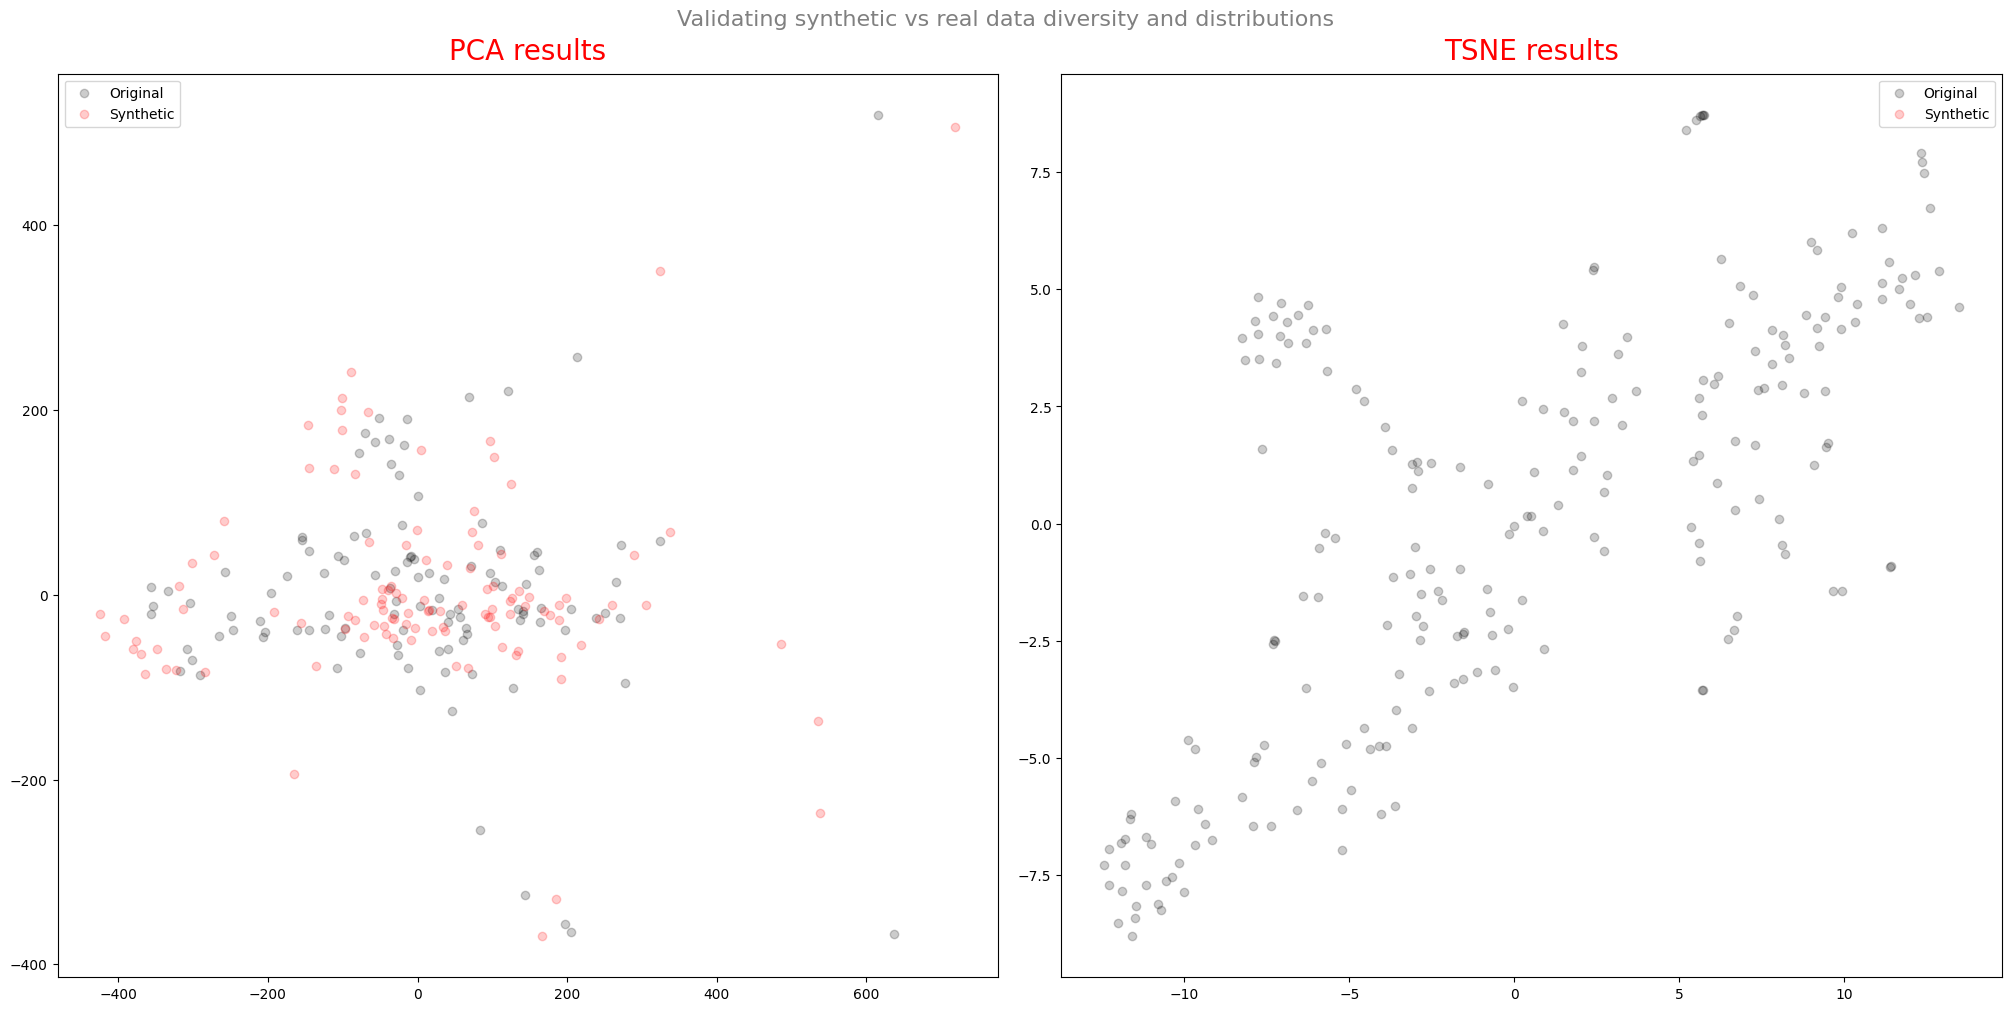

In [37]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')